<a href="https://colab.research.google.com/github/kevinsalim30/ARIMA-time-series/blob/main/Copy_of_Timeseries_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA VERSION 2

##Import Library dan Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 6 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv("/content/Domestic Arrival.csv")

In [3]:
data

,Tanggal,Jumlah_penerbangan,Jumlah_penumpang,Jumlah_kargo
0,12/2/2021,98,12417,49905
1,1/26/2022,66,8642,26829
2,2/16/2022,54,5418,25094
3,2/17/2022,56,5982,34707
4,2/25/2022,73,10614,17869
...,...,...,...,...
385,3/28/2023,68,6457,42068
386,3/29/2023,65,7357,41701
387,3/30/2023,62,7144,56637
388,3/31/2023,73,8018,42625


##Explorasi Data

In [4]:
type(data)

pandas.core.frame.DataFrame

In [5]:
# menghitung persentase nilai-nilai null (missing values) dalam setiap kolom pada suatu dataset data
data.isnull().sum()/len(data)

Tanggal               0.0
Jumlah_penerbangan    0.0
Jumlah_penumpang      0.0
Jumlah_kargo          0.0
dtype: float64

In [6]:
# untuk menghapus beberapa kolom pada dataset data
#data = data.drop(['Tanggal','Jumlah_penerbangan','Jumlah_penumpang','Jumlah_kargo'],axis='columns')
data = data.drop(['Jumlah_penumpang','Jumlah_kargo'],axis='columns')

In [7]:
print(data.dtypes)

Tanggal               object
Jumlah_penerbangan     int64
dtype: object


In [8]:
data

,Tanggal,Jumlah_penerbangan
0,12/2/2021,98
1,1/26/2022,66
2,2/16/2022,54
3,2/17/2022,56
4,2/25/2022,73
...,...,...
385,3/28/2023,68
386,3/29/2023,65
387,3/30/2023,62
388,3/31/2023,73


In [9]:
#Mengubah tanggal menjadi index
con = data['Tanggal']
data['Tanggal']=pd.to_datetime(data['Tanggal'])
data.set_index('Tanggal', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['2021-12-02', '2022-01-26', '2022-02-16', '2022-02-17',
               '2022-02-25', '2022-03-06', '2022-03-07', '2022-03-08',
               '2022-03-09', '2022-03-10',
               ...
               '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26',
               '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
               '2023-03-31', '2023-04-01'],
              dtype='datetime64[ns]', name='Tanggal', length=390, freq=None)

In [10]:
data

,Jumlah_penerbangan
Tanggal,
2021-12-02,98
2022-01-26,66
2022-02-16,54
2022-02-17,56
2022-02-25,73
...,...
2023-03-28,68
2023-03-29,65
2023-03-30,62


In [11]:
#Menginisialkan variabel High sebagai data time series
ts = data['Jumlah_penerbangan']
ts.head(10)


Tanggal
2021-12-02    98
2022-01-26    66
2022-02-16    54
2022-02-17    56
2022-02-25    73
2022-03-06    73
2022-03-07    61
2022-03-08    53
2022-03-09    64
2022-03-10    67
Name: Jumlah_penerbangan, dtype: int64

In [ ]:
#untuk menghapus baris yang memiliki nilai null pada dataset data dan menyimpan DataFrame yang baru dalam variabel ts.
#ts = data - ts.shift()
#ts = data.dropna()

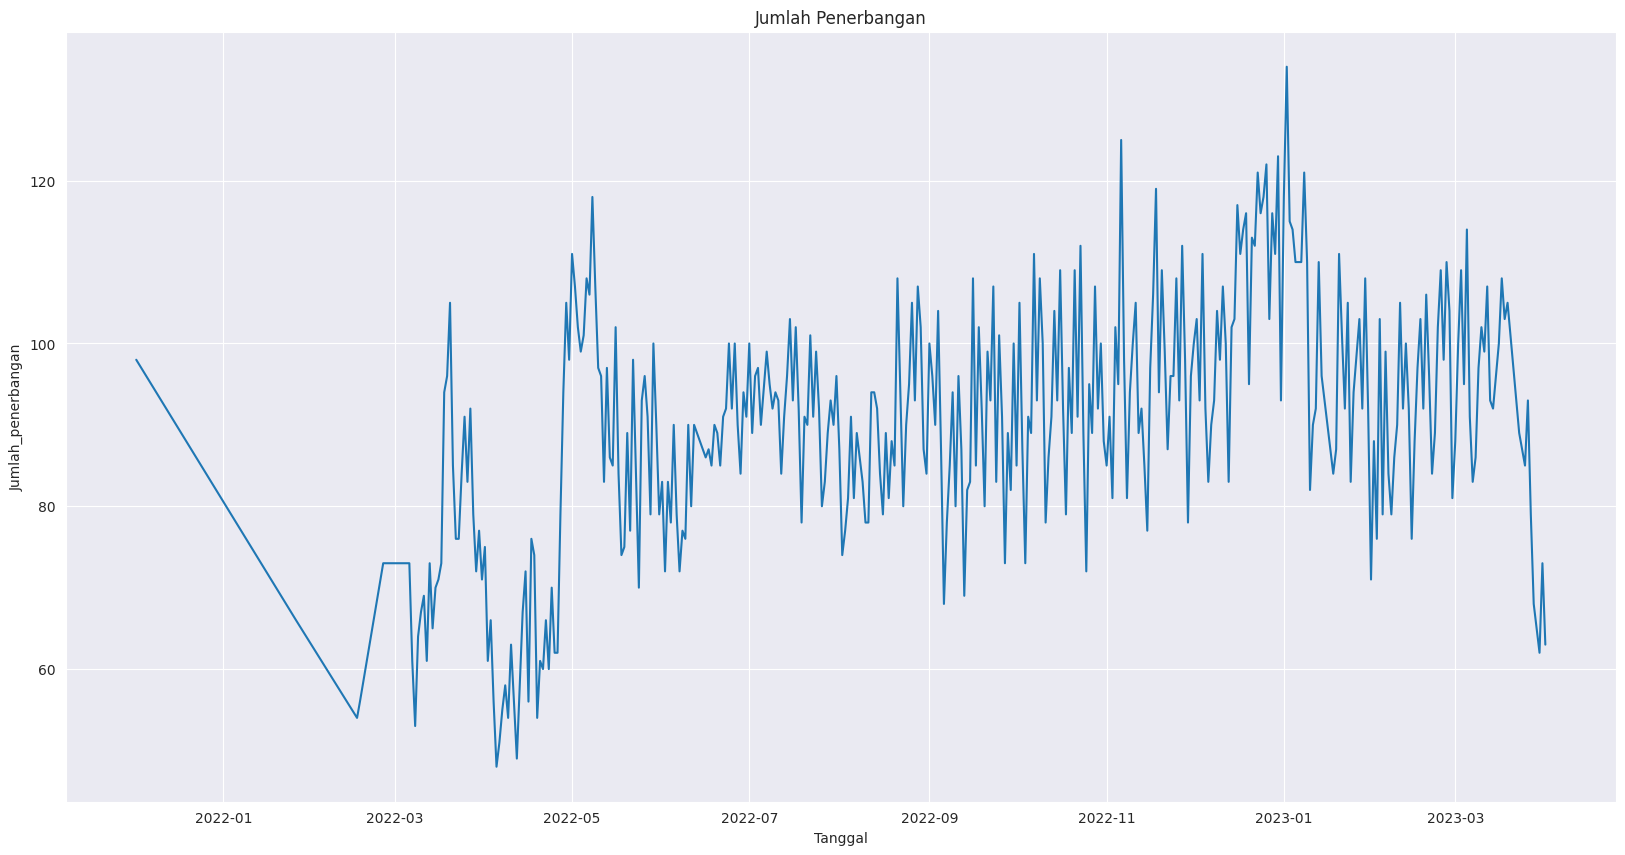

In [12]:
#Visualisasi dataset
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah_penerbangan')
plt.title('Jumlah Penerbangan')
plt.plot(data['Jumlah_penerbangan'])

In [13]:
#Deklarasi fungsi untuk mengecek stasioneritas data
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

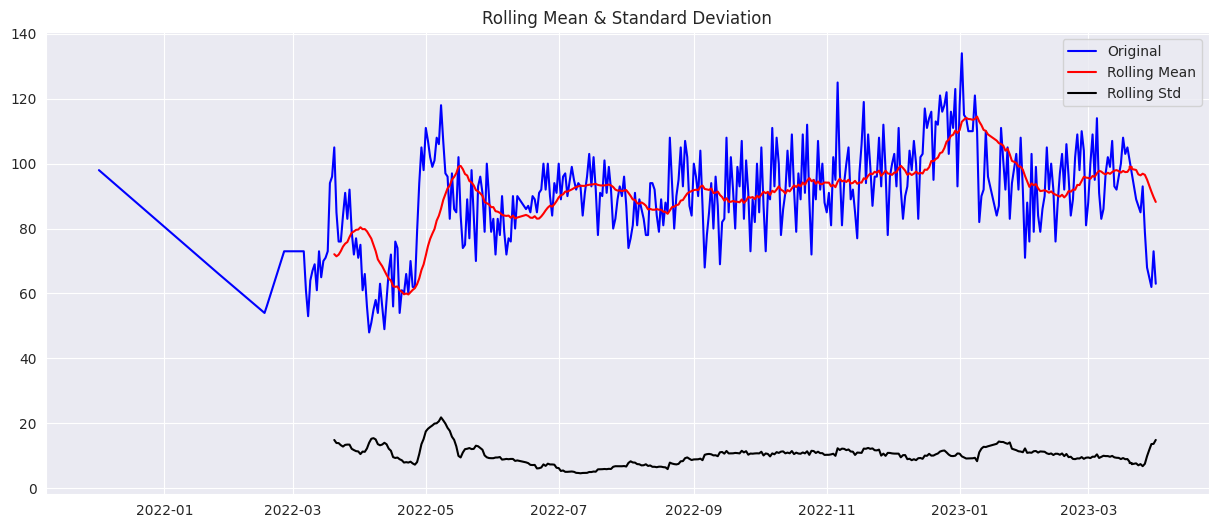

Results of Dickey-Fuller Test:
Test Statistic                  -3.031977
p-value                          0.032014
#Lags Used                      14.000000
Number of Observations Used    375.000000
Critical Value (1%)             -3.447909
Critical Value (5%)             -2.869278
Critical Value (10%)            -2.570892
dtype: float64


In [14]:
#  untuk melakukan uji stasioneritas (stationarity test) pada suatu time series data
test_stationarity(ts)

##UJI HIPOTESIS

H0 : Data tidak stasioner

Ha : Data stasioner

Tolak H0 apabila diperoleh p-value < alpha (0,05)

Diperoleh nilai p-value  0.032014 < 0,05, maka H0 ditolak.

Jadi, data sudah dalam keadaan yang stasioner. 

Jika, data memiliki keadaan yang tidak stasioner, maka perlu dilakukan proses stasionerisasi data, yakni dengan proses differencing untuk memperoleh data yang stasioner.

In [ ]:
#ts_diff_1 = ts - ts.shift()
#ts_diff_1 = ts_diff_1.dropna()
#plt.plot(ts_diff_1)

Kode ts_diff_1 = ts - ts.shift() digunakan untuk melakukan first order difference pada time series data yang disimpan pada variabel ts, yaitu mengurangi setiap nilai time series dengan nilai pada lag sebelumnya. Hal ini dilakukan untuk membuat time series data menjadi lebih stasioner (stationary) dengan menghilangkan trend atau pola yang mungkin ada pada data.

Kode ts_diff_1 = ts_diff_1.dropna() digunakan untuk menghapus nilai null yang muncul sebagai hasil dari first order difference.

Kode plt.plot(ts_diff_1) digunakan untuk memvisualisasikan time series data yang telah mengalami first order difference. Dalam plot ini, sumbu x menunjukkan waktu, sedangkan sumbu y menunjukkan nilai time series data setelah mengalami first order difference.

In [ ]:
#test_stationarity(ts_diff_1)

In [ ]:
#plt.figure()
#plt.subplot(211)
#plot_acf(ts_diff_1, ax=plt.gca(), lags=22)
#plt.subplot(212)
#plot_pacf(ts_diff_1, ax=plt.gca(), lags=22)
#plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


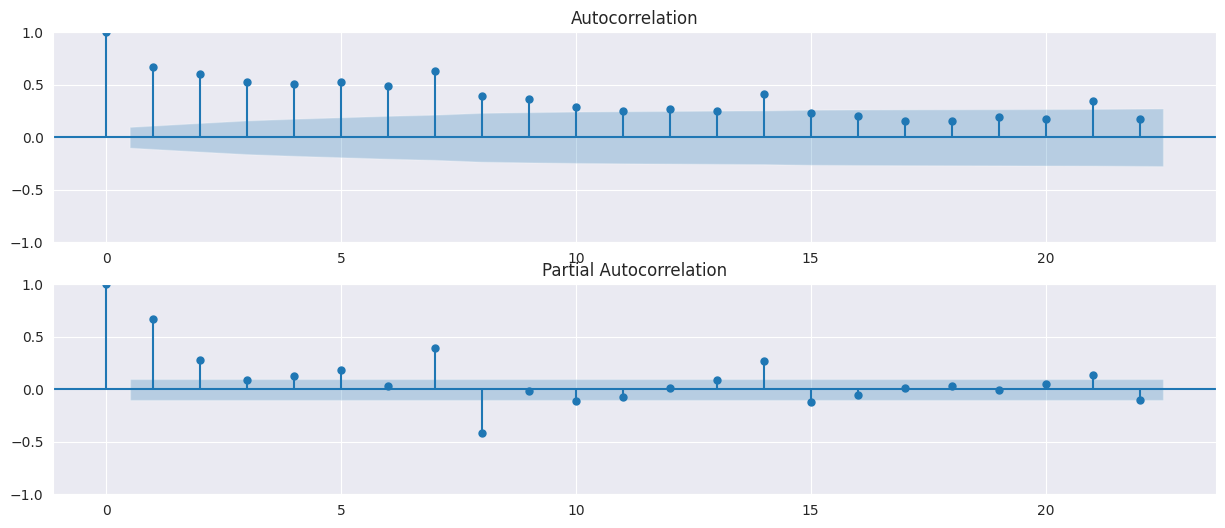

In [15]:
plt.figure()
plt.subplot(211)
plot_acf(ts, ax=plt.gca(), lags=22)
plt.subplot(212)
plot_pacf(ts, ax=plt.gca(), lags=22)
plt.show()

Kode di atas digunakan untuk menghasilkan plot Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF) dari time series data yang telah mengalami first order difference (ts_diff_1).

Fungsi plot_acf() dan plot_pacf() dari modul statsmodels.graphics.tsaplots digunakan untuk menghasilkan plot ACF dan PACF secara berurutan. Pada plot ACF, sumbu x menunjukkan lag (waktu), sedangkan sumbu y menunjukkan nilai korelasi antara time series dengan time series yang telah di-shift sebanyak lag kali. Pada plot PACF, sumbu x juga menunjukkan lag (waktu), sedangkan sumbu y menunjukkan nilai korelasi antara time series dengan time series yang telah di-shift sebanyak lag kali, tetapi dengan efek dari korelasi pada lag-lag sebelumnya sudah diperhitungkan.

Plot ACF dan PACF digunakan untuk memeriksa pola korelasi pada time series data dan menentukan parameter AR (Autoregressive) dan MA (Moving Average) pada model ARIMA (Autoregressive Integrated Moving Average) yang akan digunakan pada analisis selanjutnya.

## SARIMA